In [1]:
import datetime
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import numpy as np
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
from data_preparation import TS_Dataset

pd.set_option("display.max_rows", 100)
warnings.filterwarnings(action='ignore')

In [ ]:
# PCM Data read
pcm_df = pd.read_excel('pcm_data.xlsx')

In [ ]:
# IQC Data read
# IQC 데이터 용량 문제로 3개 File로 분할되어 있음
iqc_df = pd.DataFrame()
for i in range(3):
    iqc_df = pd.concat([iqc_df, pd.read_excel(f'iqc_data{i+1}.xlsx')])

In [ ]:
# KTA9, KTAJ 제외한 나머지 데이터
# f_pcm_df = pcm_df[~pcm_df['DEVICE'].isin(['KTA9', 'KTAJ'])]

# KTA9, KTAJ 데이터
f_pcm_df = pcm_df[pcm_df['DEVICE'].isin(['KTA9', 'KTAJ'])]

# PCM 데이터 있는 LOT 기준으로 IQC Data 필터링
f_iqc_df = iqc_df[iqc_df['LOT_NO'].isin(f_pcm_df['LOT_NO'])]

# 영문자 포함 7자리 Route에서 뒤에 4자리 숫자만 추출
f_iqc_df['ROUTE'] = [item[3:] for item in f_iqc_df['LPT']]
f_iqc_df = f_iqc_df.sort_values('ROUTE')

In [ ]:
# 이상치 제거
f_iqc_df = f_iqc_df[~(f_iqc_df['LOT_NO'] == '1102100')]

In [ ]:
f_iqc_df

,Unnamed: 0,FAC,DTTM,PROD,LPT,OPN,LOT_NO,MAIN_EQ,PARA,PARA_ALS,...,UPDATE_TIME,EDC_CHAMBER,EDC_MAIN_ROUTE_DESC,EDC_MASK,EDC_RECIPE_ID,EDC_OWNER_CODE,EDC_SWR_FLAG,SLOT_NO,CL,ROUTE
648375,1648375,AFB1,2021-09-17 16:12:39,D153KTAKA01U,LAM0055,2940,1260130,DDOX11,THK39S,THK39S,...,2021-09-17 16:30:12,POINT_6,1ST OXIDATION,KTAK,DNTK200,,N,126013.S,NaN,0055
148272,2148272,AFB1,2022-05-12 13:43:50,D155TE72001U,LAM0055,2940,2132330,DDOX22,THK39S,THK39S,...,2022-05-12 14:00:26,POINT_3,1ST OXIDATION,TE72,DNTK200,,N,213233.S,NaN,0055
418349,1418349,AFB1,2022-09-10 13:49:46,D155TE72001U,LAM0055,2940,2253190,DDOX41,THK39S,THK39S,...,2022-09-10 14:10:15,POINT_4,1ST OXIDATION,TE72,DNTK200,,N,225319.S,NaN,0055
699880,699880,AFB1,2020-12-14 20:50:31,D153WWA3001U,LAH0055,2940,0349130,DDOX11,THK39S,THK39S,...,2020-12-14 21:10:46,POINT_3,1ST OXIDATION,WWA3,DNTK200,,N,034913.S,NaN,0055
455554,455554,AFB1,2020-07-14 01:08:52,D154HL39B01U,LAH0055,2940,0195210,DDOX11,THK39S,THK39S,...,2020-07-14 01:20:37,POINT_2,1ST OXIDATION,HL39,DNTK200,,N,019521.S,NaN,0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756879,2756879,AFB1,2022-12-28 04:37:31,D153MN09C01U,LAG9263,6780,2328150,ERBO16,THK19AS,THK19AS,...,2022-12-28 04:50:12,NaN,F/O NIT ETCH,MN09,FU-N06K,,N,232815.S,NaN,9263
755544,2755544,AFB1,2020-09-21 17:30:49,D153MN09A01U,LAG9263,6780,0234170,ERBO04,THK19AS,THK19AS,...,2020-09-21 17:50:32,NaN,F/O NIT ETCH,MN09,FUSENIT,,Y,023417.S,NaN,9263
756402,2756402,AFB1,2022-12-28 01:31:42,D153MN09C01U,LAG9263,4040,2328140,ERBO16,THK19AS,THK19AS,...,2022-12-28 01:50:10,NaN,F/O NIT ETCH,MN09,FU-N06K,,N,232814.S,NaN,9263
755110,2755110,AFB1,2020-08-07 12:59:04,D153MN09A01U,LAG9263,4040,0182100,ERBO04,THK19AS,THK19AS,...,2020-08-07 13:20:39,NaN,F/O NIT ETCH,MN09,FUSENIT,,N,018210.S,NaN,9263


In [ ]:
f_iqc_df['MAIN_EQ'] = f_iqc_df['ROUTE'] + '_' + f_iqc_df['MAIN_EQ'] + '_' + f_iqc_df['EDC_CHAMBER'].fillna('')

In [7]:
f_iqc_df

,Unnamed: 0,FAC,DTTM,PROD,LPT,OPN,LOT_NO,MAIN_EQ,PARA,PARA_ALS,...,UPDATE_TIME,EDC_CHAMBER,EDC_MAIN_ROUTE_DESC,EDC_MASK,EDC_RECIPE_ID,EDC_OWNER_CODE,EDC_SWR_FLAG,SLOT_NO,CL,ROUTE
148968,148968,AFB1,2022-01-15 21:22:02,D153KTAJ001U,LAM0055,2940,2015160,0055_DDOX03_POINT_3,THK39S,THK39S,...,2022-01-15 21:40:15,POINT_3,1ST OXIDATION,KTAJ,DNTK200,,N,201516.S,NaN,0055
110425,110425,AFB1,2021-05-30 21:07:05,D153KTA9F01U,LAM0055,2940,1150160,0055_DDOX11_POINT_3,THK39S,THK39S,...,2021-05-30 21:20:04,POINT_3,1ST OXIDATION,KTA9,DNTK200,,N,115016.S,NaN,0055
207562,1207562,AFB1,2022-08-31 13:34:12,D153KTA9F01U,LAM0055,2940,2243140,0055_DDOX06_POINT_4,THK39S,THK39S,...,2022-08-31 13:50:15,POINT_4,1ST OXIDATION,KTA9,DNTK200,,N,224314.S,NaN,0055
303465,2303465,AFB1,2022-09-28 00:47:16,D153KTA9F01U,LAM0055,2940,2270210,0055_DDOX22_POINT_6,THK39S,THK39S,...,2022-09-28 01:00:12,POINT_6,1ST OXIDATION,KTA9,DNTK200,,N,227021.S,NaN,0055
325692,2325692,AFB1,2021-12-03 15:57:31,D153KTAJ001U,LAM0055,2940,1337110,0055_DDOX22_POINT_2,THK39S,THK39S,...,2021-12-03 16:10:22,POINT_2,1ST OXIDATION,KTAJ,DNTK200,,N,133711.S,NaN,0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234026,1234026,AFB1,2022-02-09 05:02:47,D153KTAJ001U,LAG7146,4925,1361150,7146_ETCP04_,CD15AS,CD15AS,...,2022-11-07 14:36:14,NaN,METAL-3 ETCH,KTAJ,270Q-TMU,NaN,N,136115.S,NaN,7146
626159,1626159,AFB1,2022-03-08 19:48:09,D153KTAJ001U,LAG7146,4925,2028150,7146_ETCP10_,CD15AS,CD15AS,...,2022-11-07 14:36:14,NaN,METAL-3 ETCH,KTAJ,270Q-TMU-HP,NaN,N,202815.S,NaN,7146
340724,2340724,AFB1,2023-04-06 02:42:55,D153KTAJB01U,LAG7146,4925,3066230,7146_ETCP03_,CD15AS,CD15AS,...,2023-04-06 03:00:18,NaN,METAL-3 ETCH,KTAJ,270SQ-TMH,,N,306623.S,NaN,7146
938772,1938772,AFB1,2021-06-05 15:51:49,D153KTA9F01U,LAG7146,4925,1118110,7146_EDPS07_FBCE,CD15AS,CD15AS,...,2021-06-05 16:10:04,FBCE,METAL-3 ETCH,KTA9,270Q-TMU,,N,111811.S,NaN,7146


In [ ]:
layer_list = f_iqc_df['ROUTE'].unique()

In [ ]:
layer_list

array(['0055', '0061', '0062', '0075', '0085', '0090', '0235', '0350',
       '0500', '0530', '0680', '1180', '1320', '1360', '1400', '1410',
       '1412', '1435', '1440', '1450', '1484', '1503', '1504', '1530',
       '1537', '1582', '1584', '1666', '1668', '1691', '1700', '1709',
       '1718', '1740', '1746', '1747', '1754', '1756', '1758', '1762',
       '1784', '1787', '1788', '1794', '1900', '1953', '2000', '2061',
       '2085', '2093', '2130', '2160', '2250', '2300', '2850', '2870',
       '2906', '2907', '2908', '3282', '3284', '3288', '3300', '3300-01',
       '3320-01', '3350', '3355', '3390', '3394', '3500', '3554', '3580',
       '360-01', '3600', '3760', '3850', '4578', '4600', '4800', '4830',
       '4853', '4870', '4875', '50', '5160', '5165', '5800', '5865',
       '6070', '6100', '6120-01', '6145', '6320', '6400', '6445', '6591',
       '6600', '6645', '6646', '6820', '6871', '6900', '6945', '7083',
       '7091', '7100', '7145', '7146', '7320', '7400', '7445', '7563

In [ ]:
total_eq_df = pd.DataFrame(f_pcm_df['LOT_NO'], columns = ['LOT_NO'])

In [ ]:
total_eq_df

,LOT_NO
0,7311411
1,8037010
2,8037020
3,8037030
4,8046010
...,...
5094,3153130
5095,3126220
5096,3140160
5097,3147180


In [10]:
step = f_iqc_df[f_iqc_df['ROUTE']== '1953']
print('1953')
print(step)


1953
        Unnamed: 0   FAC                DTTM          PROD      LPT   OPN  \
604587     1604587  AFB1 2023-03-12 00:19:15  D153KTA9F01U  LAV1953  3750   
604586     1604586  AFB1 2023-03-12 00:19:15  D153KTA9F01U  LAV1953  3750   
880990      880990  AFB1 2023-03-18 14:12:20  D153KTAJB01U  LAV1953  3750   
611261     1611261  AFB1 2021-10-01 09:10:58  D153KTAJ001U  LAT1953  3750   
611260     1611260  AFB1 2021-10-01 09:10:58  D153KTAJ001U  LAT1953  3750   
...            ...   ...                 ...           ...      ...   ...   
829844      829844  AFB1 2021-05-02 11:32:51  D153KTA9F01U  LAT1953  3750   
513819      513819  AFB1 2022-03-25 21:47:36  D153KTAJ001U  LAT1953  3750   
513820      513820  AFB1 2022-03-25 21:47:36  D153KTAJ001U  LAT1953  3750   
829843      829843  AFB1 2021-05-02 11:32:51  D153KTA9F01U  LAT1953  3750   
829842      829842  AFB1 2021-05-02 11:32:51  D153KTA9F01U  LAT1953  3750   

         LOT_NO       MAIN_EQ    PARA PARA_ALS  ...         UPDATE_TIM

In [10]:
print(sorted(set(step['PARA'])))

['2X', '2Y', '3X', '3Y', 'CD15AS', 'DCD15AS', 'MAG', 'MAG-X', 'MAG-Y', 'MCD15AS', 'MS-X', 'MS-Y', 'ORT', 'R/R', 'SA_MAG', 'SA_ROT', 'SCAL-X', 'SCAL-Y', 'SCD15AS', 'SKEW', 'W_ROT', 'X_MAX', 'X_MIN', 'Y_MAX', 'Y_MIN']


In [11]:
# 장비 매칭을 위한 기준 데이터 프레임 생성
total_eq_df = pd.DataFrame(f_pcm_df['LOT_NO'], columns = ['LOT_NO'])

# 모델을 통한 Feature Selection
# 원하는 레이어 선택해서 조합
for item1 in ['1953', '4800', '6400']:
    step = f_iqc_df[f_iqc_df['ROUTE']== item1]
    print(item1)

    # IQC Para
    for item2 in sorted(set(step['PARA'])):
        # MCD, DCD, RCD는 제외
        if item2[:3] == 'MCD' or item2[:3] == 'DCD' or item2[:3] == 'RCD':
            continue
        step2 = step[step['PARA'] == item2]
        
        # IQC 데이터 Pivot
        vals = [f'NO_VAL{i+1}'for i in range(int(step2['NO_VAL'].max()))]
        step2_pivot = pd.pivot_table(step2[['DTTM', 'LPT', 'LOT_NO','MAIN_EQ', 'UNIT']+vals],
               index=['DTTM', 'LPT', 'LOT_NO', 'MAIN_EQ'],
               columns='UNIT',
               values=vals,
               aggfunc='last'
              )
        
        # Route_PARA에 따른 통계치
        ## Lot 별 Parameter 별 최대 최소 평균을 나타냄
        ## DTTM : Date time
        step2_pivot[f'{item1}_{item2}_AVG'] = step2_pivot.mean(axis=1)
        step2_pivot[f'{item1}_{item2}_MAX'] = step2_pivot.max(axis=1)
        step2_pivot[f'{item1}_{item2}_MIN'] = step2_pivot.min(axis=1)

        step2_pivot = step2_pivot.reset_index()[['DTTM', 'LOT_NO', f'{item1}_{item2}_AVG',f'{item1}_{item2}_MAX',f'{item1}_{item2}_MIN']]
        step2_pivot.columns = step2_pivot.columns.droplevel(1)

        step2_pivot.sort_values(by=['LOT_NO', 'DTTM'], ascending=False, inplace=True)
        
        # 중복 데이터 제거
        step2_pivot['rn'] = step2_pivot.groupby(['LOT_NO']).cumcount() + 1
        step2_pivot = step2_pivot[step2_pivot['rn'] == 1]
        step2_pivot = step2_pivot.drop(['DTTM', 'rn'], axis=1)
        
        # PCM 데이터에 IQC 데이터 merge
        f_pcm_df = pd.merge(f_pcm_df, step2_pivot, how='left', left_on='LOT_NO', right_on='LOT_NO')
    
    # IQC 데이터 중 처음에 "CD"로 측정하다 "SCD"가 새로 생성되며 데이터 측정이 끊기는 경우가 발생
    # CD 데이터를 align 하기 위한 작업
    if f'{item1}_CD15AS_AVG' in f_pcm_df.columns and f'{item1}_SCD15AS_AVG' in f_pcm_df.columns:
        f_pcm_df[f'{item1}_CD15AS_AVG'] = f_pcm_df[f'{item1}_CD15AS_AVG'].fillna(f_pcm_df[f'{item1}_SCD15AS_AVG'])
        f_pcm_df[f'{item1}_CD15AS_MAX'] = f_pcm_df[f'{item1}_CD15AS_MAX'].fillna(f_pcm_df[f'{item1}_SCD15AS_MAX'])
        f_pcm_df[f'{item1}_CD15AS_MIN'] = f_pcm_df[f'{item1}_CD15AS_MIN'].fillna(f_pcm_df[f'{item1}_SCD15AS_MIN'])
        f_pcm_df = f_pcm_df.drop([f'{item1}_SCD15AS_AVG', f'{item1}_SCD15AS_MAX', f'{item1}_SCD15AS_MIN'], axis=1)

    # 장치 One Hot Encoding
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(step[['MAIN_EQ']])
    eq_df = pd.DataFrame(ohe.transform(step[['MAIN_EQ']]), columns=list(step['MAIN_EQ'].unique()), index = step['LOT_NO']).reset_index().drop_duplicates()
    total_eq_df = pd.merge(total_eq_df, eq_df, how='left')



1953
4800
6400


In [12]:
# 결측치 처리
# 결측이 발생할 경우 이전 데이터를 채움
f_pcm_df = f_pcm_df.fillna(method='ffill')
# 과거에 측정을 안하다가 새로 측정하는 경우가 발생해서 첫번째 측정 데이터로 이전 데이터를 채움
f_pcm_df = f_pcm_df.fillna(method='bfill')
f_pcm_df = f_pcm_df.dropna()
print(len(f_pcm_df), len(f_pcm_df.columns))
print('data prepare')



1182 217
data prepare


In [ ]:
Test_pcm_df = f_pcm_df[f_pcm_df.columns[19:]]

#### Time Series Dataset

In [42]:
# 데이터 Split
X_train, X_test = train_test_split(f_pcm_df, test_size=0.1, random_state=321, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=321, shuffle=False)

Train_dataset = TS_Dataset(X_train)
Val_dataset = TS_Dataset(X_val)
Test_dataset = TS_Dataset(X_test)


# ## Data Loader
# trainloader = DataLoader(Train_dataset, batch_size=64, shuffle=False,drop_last=True)
# valloader = DataLoader(Val_dataset, batch_size=64, shuffle=False,drop_last=True)
# testloader = DataLoader(Test_dataset, batch_size=64, shuffle=False,drop_last=True)


## Data Loader
trainloader = DataLoader(Train_dataset, batch_size=16, shuffle=False,drop_last=True)
valloader = DataLoader(Val_dataset, batch_size=16, shuffle=False,drop_last=True)
testloader = DataLoader(Test_dataset, batch_size=16, shuffle=False,drop_last=True)

# for tl in trainloader:
#     print(tl[1].size()) 
len(X_train)


956

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_path = r"C:\Users\10007110\Desktop\python_proj\PCM예측\save"
epoch = 200
repeat = 1

In [44]:
from NLinear_model import NLinear


In [32]:
import random
import os
def seed_everything(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [ ]:
from train_test_val import train, test, validation

In [47]:
model = NLinear()
loss_fn = nn.MSELoss()
NLinear_optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.00001)

test_mean = 0.0
r2_mean = 0.0
sl_mean = 0.0
for rp in range(repeat):
    seed_everything(rp)
    train_losses = []
    val_losses = []
    
    rp_folder = save_path + '\\' + str(rp) + "rpeat"
    os.mkdir(rp_folder)
    for ep in range(epoch):

        model, train_loss = train(model, trainloader, NLinear_optimizer, loss_fn)
        
        model, val_loss = validation(model, valloader, NLinear_optimizer, loss_fn)
        
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}'
        .format(ep, train_loss, val_loss))

        ## .state_dict() : model의 parameter(W)만을 저장하는것임 => 다시 불러올 때 모델의 파라미터를 알고있어야함
        if len(val_losses) == 0:
            torch.save(model.state_dict(), rp_folder + '\\' + str(ep) +'_NLinear' +'.pt')
        elif min(val_losses) > val_loss:
            torch.save(model.state_dict(), rp_folder + '\\' + str(ep) +'_NLinear' +'.pt')
                    
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    ## Test
    # state_dict로 저장했기 때문에 model의 hyperparameter를 불러와야함
    model = NLinear()

    # Model_selection
    min_val_losses = val_losses.index(min(val_losses)) ## 10 epoch일 경우 0번째~9번째 까지로 나옴

    model.load_state_dict(torch.load(rp_folder + '\\' + str(min_val_losses) +'_NLinear' + '.pt'))

                
    Predacc_metric, r2_metric, sl_metric, graph_pred, graph_true = test(model, testloader)
    
    test_mean += Predacc_metric
    r2_mean += r2_metric
    sl_mean += sl_metric

test_mean = test_mean/repeat
r2_mean = r2_mean/repeat
sl_mean = sl_mean/repeat


print("acc : {}".format(test_mean))
print("r2: {}".format(r2_mean))
print("sl: {}".format(sl_mean))

Epoch 0, Loss(train/val) 0.00556/0.00153
Epoch 1, Loss(train/val) 0.00551/0.01642
Epoch 2, Loss(train/val) 0.01700/0.04535
Epoch 3, Loss(train/val) 0.02620/0.06702
Epoch 4, Loss(train/val) 0.03930/0.03659
Epoch 5, Loss(train/val) 0.03481/0.00597
Epoch 6, Loss(train/val) 0.01223/0.00161
Epoch 7, Loss(train/val) 0.00368/0.00140
Epoch 8, Loss(train/val) 0.00214/0.00140
Epoch 9, Loss(train/val) 0.00191/0.00139
Epoch 10, Loss(train/val) 0.00187/0.00140
Epoch 11, Loss(train/val) 0.00186/0.00139
Epoch 12, Loss(train/val) 0.00186/0.00140
Epoch 13, Loss(train/val) 0.00186/0.00139
Epoch 14, Loss(train/val) 0.00186/0.00140
Epoch 15, Loss(train/val) 0.00186/0.00140
Epoch 16, Loss(train/val) 0.00187/0.00141
Epoch 17, Loss(train/val) 0.00187/0.00142
Epoch 18, Loss(train/val) 0.00189/0.00147
Epoch 19, Loss(train/val) 0.00192/0.00155
Epoch 20, Loss(train/val) 0.00201/0.00181
Epoch 21, Loss(train/val) 0.00222/0.00242
Epoch 22, Loss(train/val) 0.00283/0.00434
Epoch 23, Loss(train/val) 0.00447/0.00947
Ep

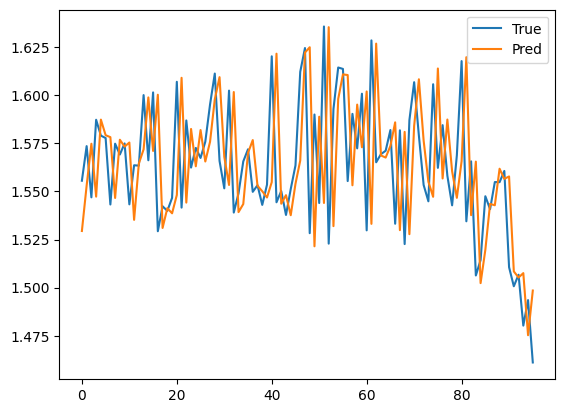

In [48]:
import matplotlib.pyplot as plt

base = [i for i in range(len(graph_pred))]
plt.plot(base,graph_true, label='True')
plt.plot(base,graph_pred, label='Pred')
plt.legend()

In [212]:
gp = graph_pred

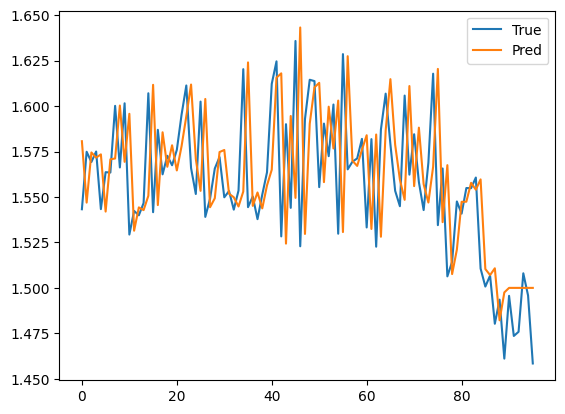

In [213]:
import matplotlib.pyplot as plt
base = [i for i in range(len(graph_pred))]

gp = np.concatenate((gp[6:],np.array([1.5,1.5,1.5,1.5,1.5,1.5])))

plt.plot(base,graph_true, label='True')
plt.plot(base,gp, label='Pred')
plt.legend()
